## Lecture 2 - $25^{th}$ November 2024
#### Lecture 2 on Variational Quantum Algorithm
<br>
This notebook presentation is part of my lecture material for the Advanced Quantum Mechanics course at the University of Trieste. It contains a general introduction to Qiskit and Pennylane

**Michele Grossi**, Coordinator of Hybrid Quantum Computing Infrastracture and Algorithms @ CERN


## Variational Quantum Algorithms

Variational Quantum Algorithms (VQA) are hybrid algorithm that use a classical optimizer to train a parameterized quantum circuit to approximate solutions for a given problem. You will find this family of architectures for a lot of application in different fields like: Chemistry, Physics, Finance, Machine Learning and more.

VQA typically need fewer gates and qubits. In turn, they are more resistant to noise and are well suited to handle near-term quantum computer constraints.

VQA's are typically iterative. Each iteration involves both quantum and classical processing. 

Output (a measurement) from one iteration is sent to the classical optimizer which generates input (a parameter) for the next iteration:

<div>
<img src="images/qva_loop.png" width="600" align="left"/>
</div>

### VQE - Application to Physics to study static properties

The Variational Quantum Eigensolver (VQE) is a central algorithm in many applications, e.g. quantum chemistry or optimization.
This tutorial shows you how to run the VQE. We'll start off by defining the algorithm settings, such as the Hamiltonian and ansatz, and then run a VQE.

In [1]:
# VQE with PennyLane: Ground State of a 5-Qubit Hamiltonian
import pennylane as qml
from pennylane import numpy as np
from scipy.linalg import eigh

# 1. Define the problem Hamiltonian
def define_hamiltonian():
    """Construct the Hamiltonian for the VQE problem."""
    coeffs = np.random.uniform(-1, 1, 15)  # Random coefficients
    obs = [
        qml.PauliZ(0) @ qml.PauliZ(1),
        qml.PauliZ(1) @ qml.PauliZ(2),
        qml.PauliZ(2) @ qml.PauliZ(3),
        qml.PauliZ(3) @ qml.PauliZ(4),
        qml.PauliZ(0) @ qml.PauliZ(4),
        qml.PauliX(0),
        qml.PauliX(1),
        qml.PauliX(2),
        qml.PauliX(3),
        qml.PauliX(4),
        qml.PauliY(0) @ qml.PauliY(1),
        qml.PauliY(2) @ qml.PauliY(3),
        qml.PauliY(3) @ qml.PauliY(4),
        qml.PauliY(0) @ qml.PauliY(4),
        qml.PauliZ(1) @ qml.PauliZ(3),
    ]
    return qml.Hamiltonian(coeffs, obs)

hamiltonian = define_hamiltonian()
n_qubits = 5

/Users/sebastianopian/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Classical solution for comparison
def classical_ground_state(hamiltonian):
    """Compute the ground state energy of the Hamiltonian classically."""
    hamiltonian_matrix = qml.matrix(hamiltonian)  # Get the matrix representation
    eigenvalues, _ = eigh(hamiltonian_matrix)     # Diagonalize the matrix
    return min(eigenvalues)

# Compute classical ground state
classical_solution = classical_ground_state(hamiltonian)
print(f"Classical ground state energy: {classical_solution:.6f}")

Classical ground state energy: -3.039679


(<Figure size 1000x600 with 1 Axes>, <Axes: >)

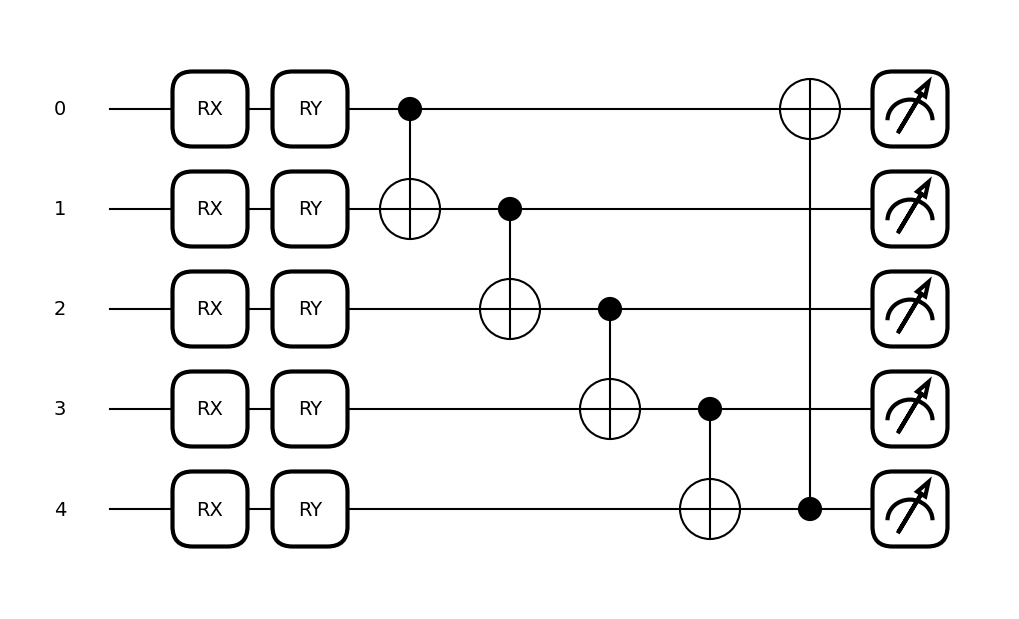

In [3]:
# 3. Define the VQE quantum circuit
dev = qml.device("default.qubit", wires=n_qubits)

def variational_ansatz(params):
    """Define the variational ansatz."""
    for i in range(n_qubits):
        qml.RX(params[i], wires=i)
        qml.RY(params[i + n_qubits], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[n_qubits - 1, 0])  # Wrap around


# Define the QNode
@qml.qnode(dev)
def circuit(params):
    variational_ansatz(params)
    return qml.expval(hamiltonian)
    

# Generate random parameters
np.random.seed(42)
params = np.random.uniform(0, 2 * np.pi, 2 * n_qubits)

# Draw the circuit
qml.draw_mpl(circuit)(params)

In [4]:
# 4. Optimize the VQE
np.random.seed(42)
init_params = np.random.uniform(0, 2 * np.pi, 2 * n_qubits)

optimizer = qml.GradientDescentOptimizer(stepsize=0.4)
params = init_params
max_iter = 100
convergence_tol = 1e-6

energy = []
for n in range(max_iter):
    params, cost = optimizer.step_and_cost(circuit, params)
    energy.append(cost)
    print(f"Iteration {n+1}: Energy = {cost:.6f}")
    if len(energy) > 2 and np.abs(energy[-1] - energy[-2]) < convergence_tol:
        break

print(f"VQE estimated ground state energy: {cost:.6f}")


Iteration 1: Energy = 0.929233
Iteration 2: Energy = 0.401398
Iteration 3: Energy = -0.059067
Iteration 4: Energy = -0.435415
Iteration 5: Energy = -0.672711
Iteration 6: Energy = -0.802783
Iteration 7: Energy = -0.883578
Iteration 8: Energy = -0.949752
Iteration 9: Energy = -1.014931
Iteration 10: Energy = -1.081692
Iteration 11: Energy = -1.147123
Iteration 12: Energy = -1.206631
Iteration 13: Energy = -1.257200
Iteration 14: Energy = -1.298814
Iteration 15: Energy = -1.333593
Iteration 16: Energy = -1.364178
Iteration 17: Energy = -1.392744
Iteration 18: Energy = -1.420771
Iteration 19: Energy = -1.449184
Iteration 20: Energy = -1.478593
Iteration 21: Energy = -1.509537
Iteration 22: Energy = -1.542725
Iteration 23: Energy = -1.579223
Iteration 24: Energy = -1.620543
Iteration 25: Energy = -1.668558
Iteration 26: Energy = -1.725091
Iteration 27: Energy = -1.791034
Iteration 28: Energy = -1.864959
Iteration 29: Energy = -1.941911
Iteration 30: Energy = -2.013943
Iteration 31: Energy 

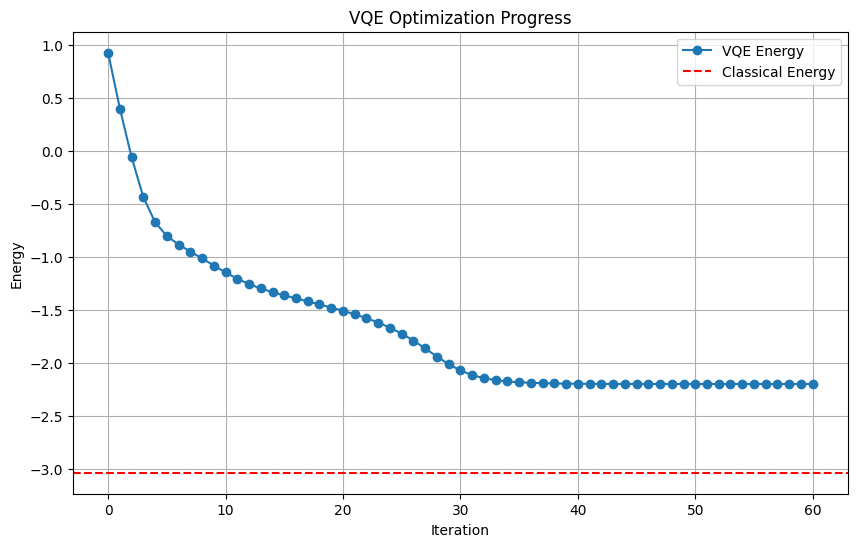

In [5]:
# 5. Compare classical and VQE results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(energy, label="VQE Energy", marker="o")
plt.axhline(y=classical_solution, color="r", linestyle="--", label="Classical Energy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Optimization Progress")
plt.legend()
plt.grid()
plt.show()


#### Discussion about Pennylane return functions
PennyLane offers various return types to extract different kinds of information from quantum circuits. The difference between `qml.state()` and `qml.expval(hamiltonian)` lies in the type of information returned and its intended use.

1. qml.state()

* Purpose:
    Returns the full quantum state (statevector) of the system after executing the circuit.
* Output:
    A complex-valued array representing the amplitudes of the quantum state.
    Useful for inspecting or debugging the complete state of the system.
* Usage:
    Typically used in simulations, where the statevector is accessible.
    When you need detailed information about the full quantum state.
    Ideal for debugging or verifying intermediate results in simulations.
  

In [6]:
@qml.qnode(dev) 
def circuit(params):
    variational_ansatz(params)
    return qml.state()

If the system is in a state $|\psi >  = \alpha|0> + \beta |1>$  calling `qml.state()` would return the vector $[\alpha, \beta] $

If the system is in a state $|\psi >  = \alpha|0> + \beta |1>$  calling `qml.state()` would return the vector $[\alpha, \beta] $

2. qml.expval(hamiltonian)

* Purpose:
Computes the expectation value of a given observable (e.g., a Hamiltonian) with respect to the final quantum state.
* Output:
A scalar value representing the expected measurement outcome of the observable.
This is the average value you would obtain if you repeatedly measured the observable on the prepared state.
* Usage:
Used in tasks like Variational Quantum Eigensolvers (VQE) to estimate the ground state energy of a Hamiltonian.
Suitable for tasks involving real quantum hardware or noisy simulators.

In [7]:
@qml.qnode(dev)
def circuit(params):
    variational_ansatz(params)
    return qml.expval(hamiltonian)


If the system is in state $ |\psi >$ and the Hamiltonian is $H$ the expectation value is computed as $ <\psi | H | \psi >$

### Qiskit VQE

**Note:** You can find tutorials on solving more comprehensive problems, such as finding the ground state of the lithium hydride molecule, using the VQE within [the tutorials of Qiskit Nature](https://qiskit-community.github.io/qiskit-nature/tutorials/index.html).

we want to use a variational algorithm to find the eigenvalue of the following observable:

$O_1 = 2II−2XX+3YY−3ZZ$ 

This observable has the following eigenvalues: $\lambda_0 = -6, \lambda_1 = 4, \lambda_2 = 4, \lambda_3 = 6$

In [8]:
from qiskit.quantum_info import SparsePauliOp

observable_1 = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

### Building VQE from scratch

We'll first explore how to construct a VQE instance manually to find the lowest eigenvalue for $O_1$.

In [9]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    return cost

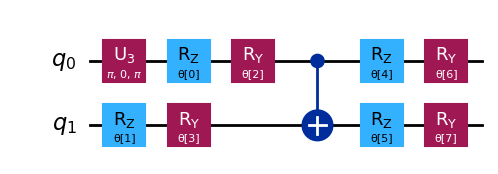

In [10]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit

import numpy as np

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
raw_ansatz = reference_circuit.compose(variational_form)

raw_ansatz.decompose().draw('mpl')

In [11]:
## Let's start on local simulators

from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
estimator = Estimator()
sampler = Sampler()

In [12]:
## initial parameters 
import numpy as np

x0 = np.ones(raw_ansatz.num_parameters)
print(x0)

[1. 1. 1. 1. 1. 1. 1. 1.]


We can minimize this cost function to calculate optimal parameters

In [13]:
# SciPy minimizer routine
from scipy.optimize import minimize
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA", options={'maxiter': 1000, 'disp': True})

end_time = time.time()
execution_time = end_time - start_time


   Normal return from subroutine COBYLA

   NFVALS =  123   F =-6.000000E+00    MAXCV = 0.000000E+00
   X = 1.281322E+00   9.423508E-01   1.570825E+00   3.631211E-05   1.917020E+00
       1.224584E+00   6.217758E-01   6.217610E-01


In [14]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999993368837
       x: [ 1.281e+00  9.424e-01  1.571e+00  3.631e-05  1.917e+00
            1.225e+00  6.218e-01  6.218e-01]
    nfev: 123
   maxcv: 0.0

we can check this by using NumPy's linear algebra eigensolver due to the small dimension of the problem.

In [15]:
from numpy.linalg import eigvalsh

solution_eigenvalue = min(eigvalsh(observable_1.to_matrix()))

print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")

print(
    f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

Number of iterations: 123
Time (s): 0.30759382247924805
Percent error: 1.11e-09


#### Experimenting with different optimizers
We can adjust the optimizer using SciPy `minimize`'s  method  argument, with more options found here. We originally used a constrained minimizer (  `COBYLA`  ). In this example, we'll explore using an unconstrained minimizer (  `BFGS`  ) instead

In [16]:
import time
start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="BFGS")

end_time = time.time()
execution_time = end_time - start_time

In [17]:
print("CHANGED TO BFGS OPTIMIZER:")
print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")

CHANGED TO BFGS OPTIMIZER:
Number of iterations: 117
Time (s): 0.18856596946716309


#### VQE with Qiskit Primitives

In [18]:
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

In [19]:
estimator = Estimator()


# we will iterate over these different optimizers
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")

    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    #result = vqe.compute_minimum_eigenvalue(operator=observable_1)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print("\rOptimization complete      ")

Optimizer: L_BFGS_B        

/var/folders/b6/5cpxpg110g9cj088x4tmqb1h0000gn/T/ipykernel_1982/245694284.py:1: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Optimization complete      


Now, from the callback data you stored, you can plot the energy value at each objective function call each optimizer makes. An optimizer using a finite difference method for computing gradient has that characteristic step-like plot where for a number of evaluations it is computing the value for close by points to establish a gradient 

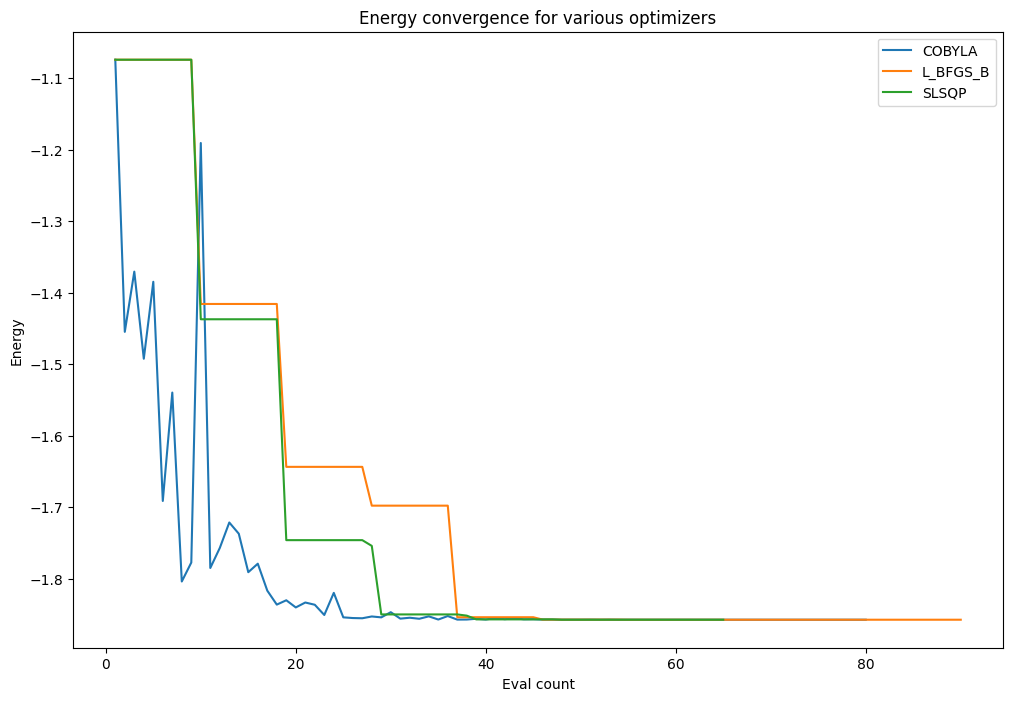

In [20]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_counts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

### Discussion on the ansatz choice
To iteratively optimize from a reference state $\rho$ to a target state $\psi(\theta)$, we need to define a variational form $U_V(\theta)$ that represents a collection of parametrized states for our variational algorithm to explore:

$U_V(\theta) U_R | 0> = U_V(\theta) \rho= U_A(\theta) = |\psi(\theta)> $

Note that the parametrized state depends on both the reference state $\rho$, which does not depend on any parameters, and the variational form $U_V(\theta)$, which always depends on parameters. We refer to the combination of these two halves as an ansatz $U_A(\theta)$. As we construct our ansatz to represent a collection of parametrized states for our variational algorithm to explore, we realize an important issue: dimensionality. An 
n-qubit system (i.e., Hilbert space) has a vast number of distinct quantum states in the configuration space. We would require an unwieldy number of parameters to fully explore it. In addition, the runtime complexity of search algorithms, and others alike, grows exponentially with this dimensionality, a phenomenon often referred to in the literature as the curse of dimensionality. 

To counter this setback, it is common practice to impose some reasonable constraints on the variational form such that only the most relevant states are explored. Finding an efficient truncated ansatz is an active area of research, but we'll cover two common designs.

#### Heuristic ansatze and trade-offs

If you do not have any information about your particular problem that can help restrict the dimensionality, you can try an arbitrary family of parameterized circuits with fewer than $2^{2n}$ parameters. However, there are some trade-offs to consider:

- Speed: By reducing the search space, the algorithm can run faster.
- Accuracy: However, reducing the space could risk excluding the actual solution to the problem, leading to suboptimal solutions.
- Noise: Deeper circuits are affected by noise, so we need to experiment with our ansatz's connectivity, gates, and gate fidelity.

**N-Local circuit**

One of the most widely used examples of heuristic ansatzes is the N-local circuits, for a few reasons:

- Efficient implementation: The N-local ansatz is typically composed of simple, local gates that can be implemented efficiently on a quantum computer, using a small number of physical qubits. This makes it easier to construct and optimize quantum circuits.
- Captures important correlations: The N-local ansatz can capture important correlations between the qubits in a quantum system, even with a small number of gates. This is because the local gates can act on neighboring qubits and create entanglement between them, which can be important for simulating complex quantum systems.

These circuits consist of rotation and entanglement layers that are repeated alternatively one or more times as follows:
- Each layer is formed by gates of size at most N, where N has to be lower than the number of qubits.
- For a rotation layer, the gates are stacked on top of each other. We can use standard rotation operations (RX.RZ)
- For an entanglement layer, we can use gates like Toffoligates or  CX  with an entanglement strategy.

  
Example: 5 qubits with Toffoli gate, which acts on three qubits, making the circuit `3-local`

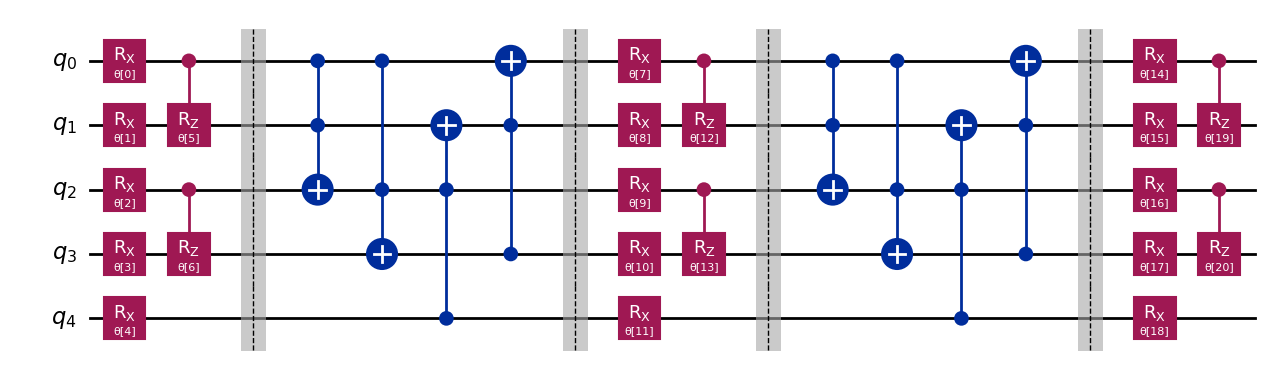

In [21]:
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate
from qiskit.circuit import Parameter

theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=5,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [0, 2, 3], [4, 2, 1], [3, 1, 0]],
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

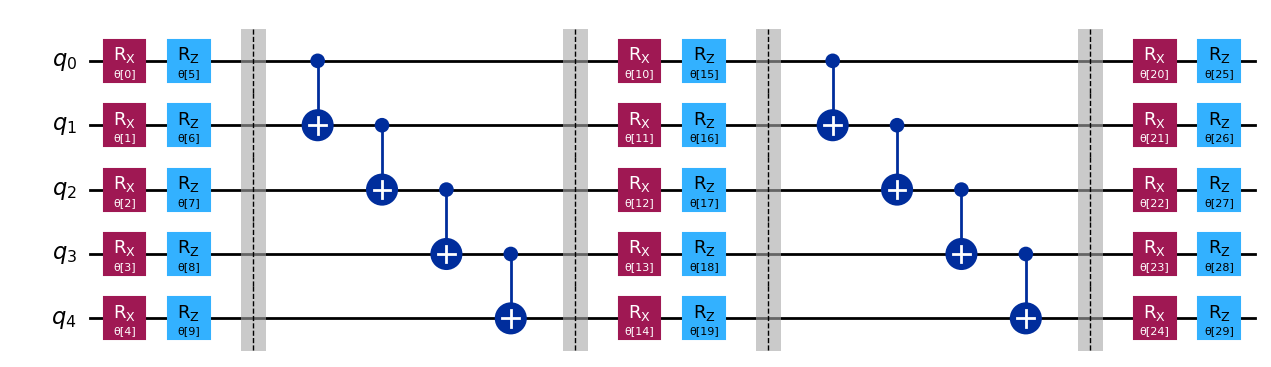

In [22]:
## Example using the standard 2-local circuits with single-qubit rotation gates and 2-qubit entanglement gates.
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(
    num_qubits=5,
    rotation_blocks=["rx", "rz"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

**EfficientSU2**

EfficientSU2  is a hardware-efficient circuit that consists of layers of single-qubit operations spanning $SU(2)$ and  $CX$ entanglements. This is a heuristic pattern that can be used to prepare trial wave functions for variational quantum algorithms or as a classification circuit for machine learning.

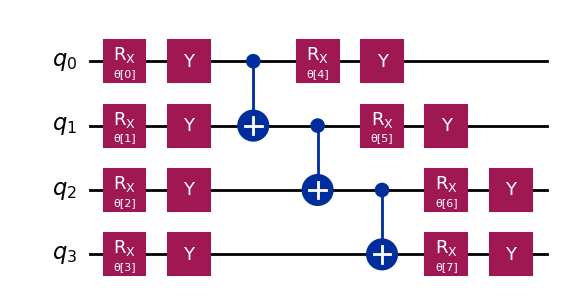

In [23]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(4, su2_gates=["rx", "y"], entanglement="linear", reps=1)
ansatz.decompose().draw("mpl")

### Extra on SU(2) ansatz

The `SU(2) ansatz` in quantum computing is deeply rooted in **group theory**, particularly in the representation theory of the special unitary group SU(2). Understanding this connection helps explain the mathematical structure behind the ansatz and why it's commonly used in variational quantum algorithms. Here's an expanded explanation of the connection:

### **SU(2) Ansatz and Its Connection to Group Theory**

### **What is SU(2)?**

- **Definition**:
  - $ SU(2) $ is the group of all $( 2 \times 2 )$ unitary matrices with determinant $( 1 )$.
  - Formally:
    $
    SU(2) = \{ U \in \mathbb{C}^{2 \times 2} : U^\dagger U = I, \det(U) = 1 \}.
    $
  - Examples of $( SU(2) )$ matrices include quantum gates such as $( R_X(\theta) )$, $( R_Y(\theta) )$, and $( R_Z(\theta) )$, which represent rotations around the $( x $-, $ y )$ -, and $( z )$-axes of the Bloch sphere.

- **Lie Algebra**:
  - The generators of $( SU(2) )$ are the **Pauli matrices** $( X, Y, Z )$ scaled by $ i/2 $.
  - Any element of $ SU(2) $ can be expressed as:
    $
    U = e^{-i (\alpha X + \beta Y + \gamma Z)},
    $
    where $ \alpha, \beta, \gamma $ are real coefficients.

---


## **SU(2) Ansatz in Variational Algorithms**

### **Structure**
- The SU(2) ansatz leverages the fact that any $ SU(2) $ operation can be expressed using parameterized rotations:
  $
  U = R_X(\theta_1) R_Y(\theta_2) R_Z(\theta_3).
  $
- By stacking layers of these gates, the ansatz explores a parameterized subset of $ SU(2) $, enabling optimization for specific problems.

### **Key Properties**
1. **Universal Approximation**:
   - A combination of local $ SU(2)$ operations (rotations) and entanglement gates is **universal**, meaning it can approximate any quantum operation on $ n $-qubits to arbitrary precision.

2. **Symmetry-Constrained Problems**:
   - Many physical systems exhibit $ SU(2) $-type symmetries (e.g., spin systems).
   - The SU(2) ansatz naturally respects these symmetries.

In [24]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 3
layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

def su2_ansatz(params):
    for i in range(n_qubits):
        qml.RX(params[0][i], wires=i)
        qml.RY(params[1][i], wires=i)
        qml.RZ(params[2][i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev)
def circuit(params):
    for layer in range(layers):
        su2_ansatz(params[layer])
    return qml.state()

params = np.random.uniform(0, 2 * np.pi, (layers, 3, n_qubits))
print("Final Quantum State:", circuit(params))


Final Quantum State: [-0.04330939+0.00197066j -0.00828894+0.08524238j -0.05249925+0.06222108j
  0.14709074-0.0832011j  -0.33261814-0.37904314j  0.09459899+0.47519876j
 -0.03768399+0.17113517j  0.65691275-0.06547249j]
